In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Use with caution
if True:
    import warnings
    warnings.filterwarnings("ignore")

# Data loading and assembly

In [3]:
spectra = pd.read_csv('../data/cleanedset.csv')
columns = ['target', 'sampleID'] 
columns.extend([str(x) for x in range(950, 1530+1,2)])
spectra = spectra[columns]
print(spectra.shape)
spectra.head()

(591, 293)


,target,sampleID,950,952,954,956,958,960,962,964,...,1512,1514,1516,1518,1520,1522,1524,1526,1528,1530
0,94.333333,0.0,36.723839,35.745964,34.811623,33.955212,33.197552,32.570518,32.147972,31.807793,...,0.791820,0.831189,0.883438,0.940272,0.993729,1.046867,1.098642,1.152454,1.215338,1.271571
1,94.333333,0.0,36.369366,35.383987,34.443897,33.584080,32.823158,32.192280,31.770844,31.431589,...,0.685869,0.728103,0.785778,0.845810,0.902551,0.961095,1.017545,1.073209,1.138063,1.196826
2,94.333333,0.0,35.385422,34.405182,33.466976,32.614578,31.862633,31.242191,30.828016,30.496775,...,0.618997,0.659589,0.712821,0.769303,0.822148,0.875681,0.929040,0.979519,1.040625,1.100850
3,94.333333,0.0,35.121685,34.145687,33.217796,32.374218,31.630789,31.019081,30.611959,30.286642,...,0.751016,0.796110,0.852175,0.909087,0.965727,1.024710,1.080235,1.133445,1.197904,1.262516
4,76.333333,1.0,36.185947,35.209904,34.280155,33.430157,32.679989,32.062084,31.647160,31.312046,...,1.001077,1.051815,1.112780,1.175900,1.240040,1.304035,1.365576,1.426388,1.495515,1.561842


# Regression

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union

## Folds definition

In [5]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=47)

## Savgol filter

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

In [6]:
from scipy.signal import savgol_filter

class Savgol(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self, window_length=5, polyorder=2, deriv=0, wavemin=950, wavemax=1530):# 
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
        self.wavemin = wavemin
        self.wavemax = wavemax
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        colnames = [str(x) for x in range(self.wavemin, self.wavemax+1,2)]
        df = X[colnames].copy(deep=True)
        toreturn = df.apply(savgol_filter, args=(self.window_length, self.polyorder, self.deriv), axis=1, raw=True, result_type='broadcast')
        return toreturn

params={'window_length':5, 'polyorder':2, 'deriv':1}
savgol = Savgol(**params)
savgol.fit_transform(spectra).shape

(591, 291)

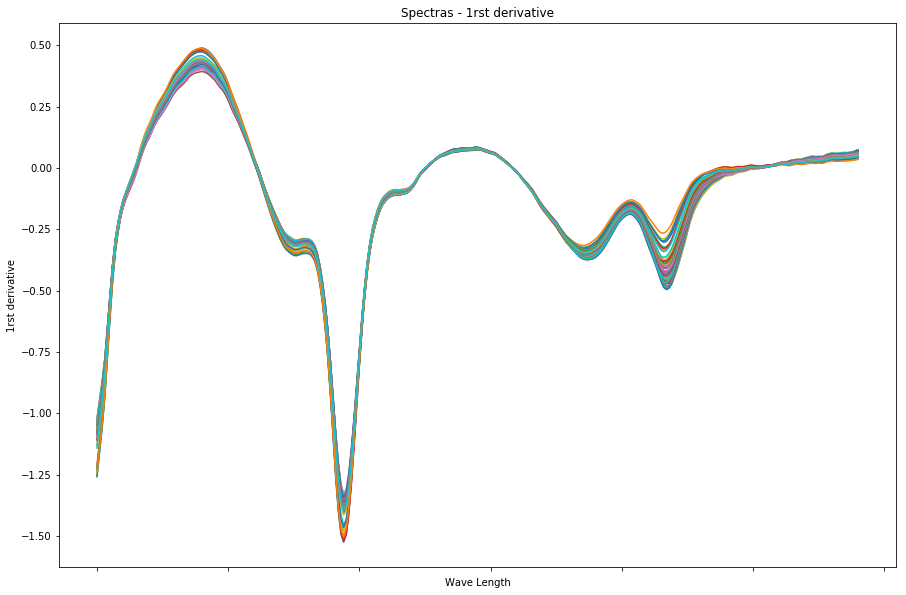

In [7]:
df = savgol.transform(spectra)
df.head(50).T.plot(legend=None, figsize=(15,10))
plt.title('Spectras - 1rst derivative')
plt.xlabel('Wave Length')
plt.ylabel('1rst derivative')
plt.show()

# Standard Normal Variate
https://www.idtools.com.au/two-scatter-correction-techniques-nir-spectroscopy-python/

In [8]:
class Snv(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.means = np.array([])
        self.stds = np.array([])
    
    def fit(self, X, y=None):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)
        #print(self.means.shape)
        return self
    
    def transform(self, X, y=None):
        data_snv = X.copy().values
    
        for index in range(data_snv.shape[1]):
            data_snv[index,:] = (data_snv[index,:] - self.means[index]) / self.stds[index]
        return pd.DataFrame(data_snv, index=X.index, columns=X.columns)

snv = Snv()
snv.fit_transform(df).shape


(591, 291)

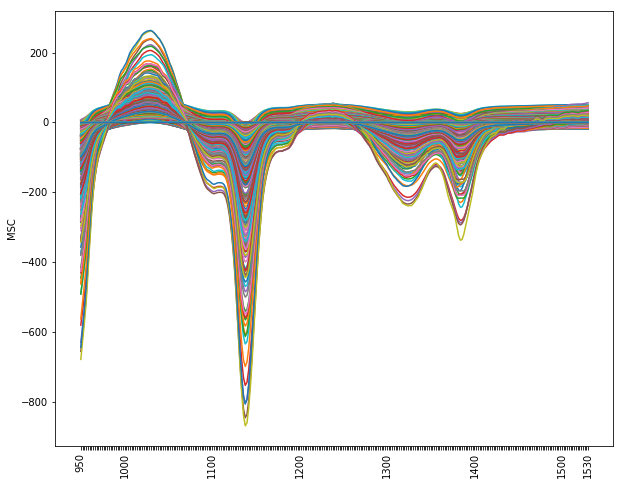

In [9]:
snv.fit_transform(df).T.plot(legend=False, figsize=(10,8))
plt.ylabel('MSC')
plt.savefig('General spectras.png')
plt.xticks(np.arange(len(df.columns)), [v if (int(v) % 100 == 0) or k==0 or k==len(df.columns)-1 else '' for (k,v) in enumerate(df.columns)], rotation=90)
plt.show()

## Blocs creation

In [10]:
params={'window_length':5, 'polyorder':2, 'deriv':1}
savgol = Savgol(**params)

In [11]:
snv = Snv()

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

# Tree construction

In [14]:
lrpipelist1 = [#('snv', snv),
               ('savgol', savgol),
               #('snv', snv),
               ('scaler', scaler),
               ('pca', pca)] #
pipe1 = Pipeline(lrpipelist1)
#Xtrans = pipe1.fit_transform(spectra)#.shape

In [15]:
pipe1.fit_transform(spectra).shape

(591, 291)

In [16]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=0, max_iter=10000)

In [17]:
listpipereg = [('pipe1', pipe1), ('ridge', ridge)] #
pipereg = Pipeline(listpipereg)

In [18]:
pipereg.fit(spectra, spectra['target'])

Pipeline(memory=None,
     steps=[('pipe1', Pipeline(memory=None,
     steps=[('savgol', Savgol(deriv=1, polyorder=2, wavemax=1530, wavemin=950, window_length=5)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=0, solver='auto', tol=0.001))])

# PCA visualisation

In [19]:

Xtrans = pipe1.fit_transform(spectra)
Xtrans.shape

(591, 291)

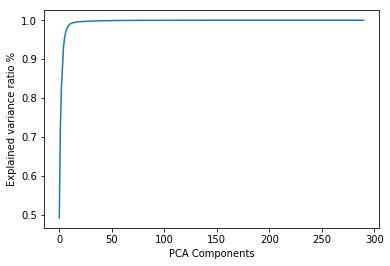

In [20]:
exp_variance_ratio_ = pipe1.named_steps['pca'].explained_variance_ratio_
cumsum=np.cumsum(exp_variance_ratio_)

plt.plot(range(cumsum.shape[0]), cumsum)
# Axis
#plt.plot([-40, 40], [0, 0], color='black', ls='--')
#plt.plot([0, 0], [-14, 14], color='black', ls='--')
# Title
#plt.title('Cumulative sum - explained variance ratio')
plt.xlabel('PCA Components')
plt.ylabel('Explained variance ratio %')
plt.savefig('misc - pca latent variable.png')
plt.show()

In [21]:
cumsum[:20]

array([0.49124441, 0.72152544, 0.82568602, 0.88017479, 0.93100178,
       0.95428137, 0.96815081, 0.97620263, 0.98303583, 0.98691969,
       0.98972409, 0.9914582 , 0.99255721, 0.99346592, 0.99412655,
       0.99463146, 0.99511788, 0.99548918, 0.99580453, 0.9960925 ])

### HyperOpt

In [22]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'savgol', 'scaler', 'pca', 'savgol__deriv', 'savgol__polyorder', 'savgol__wavemax', 'savgol__wavemin', 'savgol__window_length', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten'])

In [23]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [24]:
from sklearn.metrics import r2_score

In [25]:
counter = 0
bestscore = 1e20

def objective(params):
    #print(params)
    global counter
    global bestscore
    counter += 1
    
    hyperparams = {
        'alpha': params['alpha'],
        'random_state': 0,
        }
    
    pipe1.set_params(pca__n_components=int(params['pca__n_components']))
    pipe1.set_params(savgol__window_length=int(params['savgol__window_length'])+1)
    pipe1.set_params(savgol__deriv=int(params['savgol__deriv']))
    pipe1.set_params(savgol__wavemin=int(params['savgol__wavemin']))
    pipe1.set_params(savgol__wavemax=int(params['savgol__wavemax']))
    pipe1.set_params(savgol__polyorder=int(params['savgol__polyorder']))
    
    Xtrans = pipe1.fit_transform(spectra)
    
    ridge = Ridge(**hyperparams)
    
    preds = cross_val_predict(ridge, Xtrans, spectra['target'], cv=kf, n_jobs=-2)
    #score = mean_squared_error(spectra['target'] , preds)
    score = -r2_score(spectra['target'] , preds)
    
    
    #score = -cross_val_score(regpip, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-2).mean()
    if counter % 25 == 0:
        print("{} - RMSECV {}".format(counter, score))
        #print(params)
    if score < bestscore:
        bestscore = score
        print("{} - RMSECV {} - {}".format(counter, score, params))
    
    return score

space = {
    'alpha': hp.loguniform('alpha', -3, 0),
    'pca__n_components': hp.quniform('pca__n_components',10, 50, 1),
    'savgol__window_length': hp.quniform('savgol__window_length', 3, 19, 2),
    'savgol__deriv':hp.quniform('savgol__deriv', 1, 2, 1),
    'savgol__wavemin': hp.quniform('savgol__wavemin', 950, 1100, 2),
    'savgol__wavemax': hp.quniform('savgol__wavemax', 1300, 1530, 2),
    'savgol__polyorder':hp.quniform('savgol__polyorder', 2, 3, 1)
    
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

1 - RMSECV -0.6395432689879788 - {'alpha': 0.07162282071384056, 'pca__n_components': 26.0, 'savgol__deriv': 1.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1470.0, 'savgol__wavemin': 1030.0, 'savgol__window_length': 12.0}
9 - RMSECV -0.6442103058792679 - {'alpha': 0.08796596779336759, 'pca__n_components': 33.0, 'savgol__deriv': 1.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1348.0, 'savgol__wavemin': 952.0, 'savgol__window_length': 6.0}
10 - RMSECV -0.6586666293193266 - {'alpha': 0.6355817105794521, 'pca__n_components': 40.0, 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1460.0, 'savgol__wavemin': 1086.0, 'savgol__window_length': 18.0}
23 - RMSECV -0.6622018050553695 - {'alpha': 0.6306050731301439, 'pca__n_components': 50.0, 'savgol__deriv': 1.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1386.0, 'savgol__wavemin': 1074.0, 'savgol__window_length': 18.0}
25 - RMSECV -0.6560406363416158
28 - RMSECV -0.6660803113749787 - {'alpha': 0.7187791705527669, 'pca__n_co

In [26]:
best

{'alpha': 0.11094603236637,
 'pca__n_components': 22.0,
 'savgol__deriv': 1.0,
 'savgol__polyorder': 3.0,
 'savgol__wavemax': 1396.0,
 'savgol__wavemin': 1072.0,
 'savgol__window_length': 16.0}

In [27]:
params = {
        'alpha': best['alpha'],
        'random_state': 0,
        }

ridge = Ridge(**params)

params

{'alpha': 0.11094603236637, 'random_state': 0}

In [28]:
pipe1.set_params(pca__n_components=int(best['pca__n_components']))
pipe1.set_params(savgol__window_length=int(best['savgol__window_length'])+1)
pipe1.set_params(savgol__deriv=int(best['savgol__deriv']))
pipe1.set_params(savgol__wavemin=int(best['savgol__wavemin']))
pipe1.set_params(savgol__wavemax=int(best['savgol__wavemax']))
pipe1.set_params(savgol__polyorder=int(best['savgol__polyorder']))
pipe1.fit(spectra)
Xtrans = pipe1.transform(spectra)

In [29]:

preds = cross_val_predict(ridge, Xtrans, spectra['target'], cv=kf)
mean_squared_error(preds, spectra['target'])

23.206767981359093

In [30]:
mean_squared_error(spectra['target'], preds, )**.5

4.8173403431104065

In [31]:
from sklearn.metrics import r2_score
r2_score(spectra['target'], preds)

0.6987018093568915

## Truncated spectras

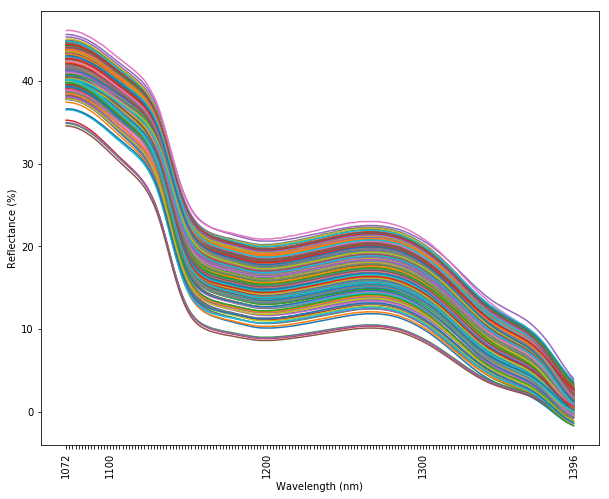

In [32]:
colnames = [str(x) for x in range(int(best['savgol__wavemin']), int(best['savgol__wavemax'])+1,2)]
df = spectra[colnames].T
df.plot(legend=False, figsize=(10,8))
#plt.title('Spectras')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.savefig('Truncated spectras.png')
plt.xticks(np.arange(len(colnames)), [v if (int(v) % 100 == 0) or k==0 or k==len(colnames)-1 else '' for (k,v) in enumerate(colnames)], rotation=90)
plt.savefig('ridge - Spectras - cleaning.png')
plt.show()

In [33]:
preds = cross_val_predict(ridge, Xtrans, spectra['target'], cv=kf)
mean_squared_error(preds, spectra['target'])

23.206767981359093

# hyper parameters Sensitivity

In [34]:
alpha_range = np.logspace(-4, 0, 21)

param_grid = dict(alpha=alpha_range)

ridge = Ridge(random_state=0, max_iter=10000)

grid = GridSearchCV(ridge, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error') #'neg_mean_squared_error'
grid.fit(Xtrans, spectra['target'])


GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=0, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([1.00000e-04, 1.58489e-04, 2.51189e-04, 3.98107e-04, 6.30957e-04,
       1.00000e-03, 1.58489e-03, 2.51189e-03, 3.98107e-03, 6.30957e-03,
       1.00000e-02, 1.58489e-02, 2.51189e-02, 3.98107e-02, 6.30957e-02,
       1.00000e-01, 1.58489e-01, 2.51189e-01, 3.98107e-01, 6.30957e-01,
       1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [35]:
grid.best_params_

{'alpha': 0.3981071705534973}

In [36]:
grid.best_score_

-23.171451457384947

In [37]:
scores = grid.cv_results_['mean_test_score']

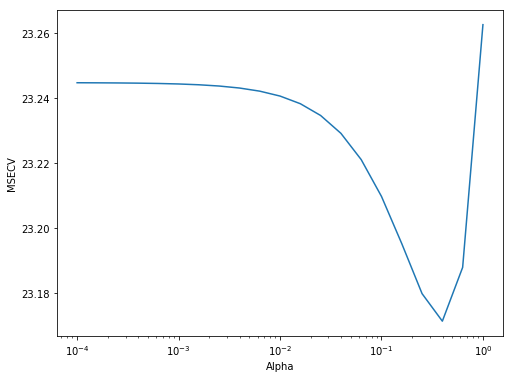

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(alpha_range, -scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSECV')
plt.savefig('ridge - sensitivity.png')
plt.show()

In [39]:
ridge = Ridge(random_state=0, max_iter=10000, **grid.best_params_)
preds = cross_val_predict(ridge, Xtrans, spectra['target'], cv=kf)
(mean_squared_error(preds, spectra['target']))**.5

4.813673384992478

## Component Selection - Linear regression - No regularization

In [40]:
rmsecv = []
components = np.arange(2,75,2)

from sklearn.linear_model import LinearRegression

for component in components:
    pipe1.set_params(pca__n_components=component)
    Xtrans = pipe1.fit_transform(spectra)
    
    lr = LinearRegression()
    
    preds = cross_val_predict(lr, Xtrans, spectra['target'], cv=kf, n_jobs=-2)
    score = mean_squared_error(spectra['target'] , preds)
    
    rmsecv.append(score)
    


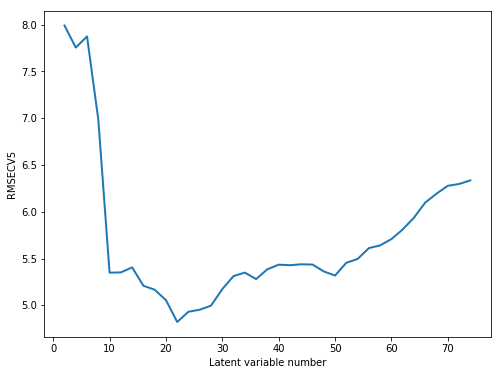

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(components, np.array(rmsecv)**.5, '-', linewidth=2)
plt.ylabel('RMSECV5')
plt.xlabel('Latent variable number')
plt.savefig('ridge - components.png')
plt.show()


## Score accuracy - Ridge

In [42]:
df = pd.DataFrame({'target':spectra['target'], 'pred':preds, 'sampleID':spectra['sampleID'],}) #
df.head()

,target,pred,sampleID
0,94.333333,96.874324,0.0
1,94.333333,101.683872,0.0
2,94.333333,100.306632,0.0
3,94.333333,99.928347,0.0
4,76.333333,79.380242,1.0


In [43]:
df['delta'] = df['target'] - df['pred']
df['deltaabs'] = np.abs(df['delta'])
df.head()

,target,pred,sampleID,delta,deltaabs
0,94.333333,96.874324,0.0,-2.540990,2.540990
1,94.333333,101.683872,0.0,-7.350539,7.350539
2,94.333333,100.306632,0.0,-5.973299,5.973299
3,94.333333,99.928347,0.0,-5.595014,5.595014
4,76.333333,79.380242,1.0,-3.046908,3.046908


In [44]:
df[['delta']].describe()

,delta
count,591.000000
mean,0.491856
std,6.321662
min,-15.639000
25%,-4.050717
50%,0.752453
75%,5.074976
max,15.536960


In [45]:
import seaborn as sns

/Users/cricket/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


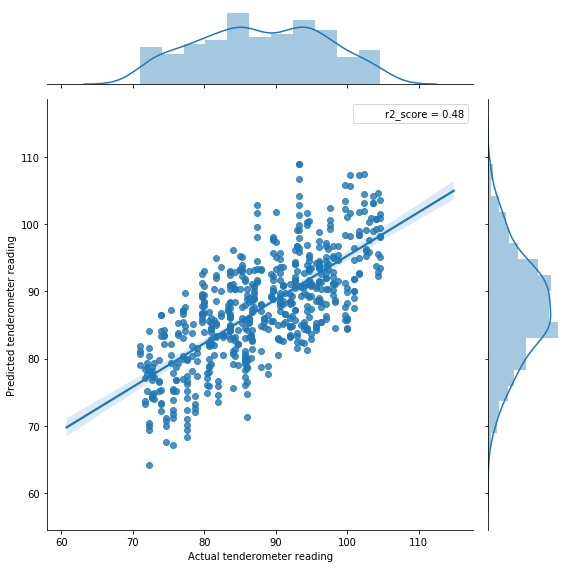

In [46]:
from scipy import stats
from sklearn.metrics import r2_score

sns.jointplot(x='target', y='pred', data=df,  height=8, stat_func=r2_score, kind='reg',)
plt.xlabel('Actual tenderometer reading')
plt.ylabel('Predicted tenderometer reading')
plt.savefig('ridge - result regression.png')
plt.show()

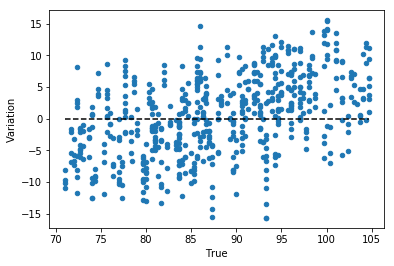

,delta
count,591.000000
mean,0.491856
std,6.321662
min,-15.639000
25%,-4.050717
50%,0.752453
75%,5.074976
max,15.536960


In [47]:

df.plot.scatter('target', 'delta')
plt.plot([df['target'].min(), df['target'].max()], [0, 0], color='k', linestyle='--')
#plt.title('Delta error ')
plt.xlabel('True')
plt.ylabel('Variation')
plt.savefig('ridge - residual.png')
plt.show()
df[['delta']].describe()

# Result saving

In [48]:
params = best
params = {**params, **grid.best_params_}
params = {**params, 'RMSE':(-grid.best_score_)**.5, 'R2':r2_score(spectra['target'], preds)}
params

{'alpha': 0.3981071705534973,
 'pca__n_components': 22.0,
 'savgol__deriv': 1.0,
 'savgol__polyorder': 3.0,
 'savgol__wavemax': 1396.0,
 'savgol__wavemin': 1072.0,
 'savgol__window_length': 16.0,
 'RMSE': 4.813673384992478,
 'R2': 0.4788838491644758}

In [49]:
samplesize = df.shape[0]
print('sample size:', samplesize)

for errorabs in [1 ,2 ,3 ,4 ,6 ,8, 10]:
    correctcount = df[df['deltaabs'] < errorabs].shape[0]
    percent = correctcount/samplesize
    print('prediction +/- {:.1f} : percent {:05.02f} %'.format(errorabs, percent*100))
    params = {**params, 'preds +/-{}'.format(int(errorabs)):percent}


sample size: 591
prediction +/- 1.0 : percent 11.34 %
prediction +/- 2.0 : percent 22.00 %
prediction +/- 3.0 : percent 33.67 %
prediction +/- 4.0 : percent 44.67 %
prediction +/- 6.0 : percent 61.42 %
prediction +/- 8.0 : percent 76.65 %
prediction +/- 10.0 : percent 88.49 %


In [50]:
resultset = pd.DataFrame(params, index=['ridge'])
resultset.to_csv('../data/res_ridge.csv')
resultset

,alpha,pca__n_components,savgol__deriv,savgol__polyorder,savgol__wavemax,savgol__wavemin,savgol__window_length,RMSE,R2,preds +/-1,preds +/-2,preds +/-3,preds +/-4,preds +/-6,preds +/-8,preds +/-10
ridge,0.398107,22.0,1.0,3.0,1396.0,1072.0,16.0,4.813673,0.478884,0.113367,0.219966,0.336717,0.446701,0.614213,0.766497,0.884941
